/Users/aleksandrbabushkin/ITMO/6th-semester/neurotechnology-affective-computing/s6-neuro-project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


              precision    recall  f1-score   support

        гнев       0.00      0.00      0.00       1.0
    нейтраль       0.00      0.00      0.00       0.0
       страх       0.00      0.00      0.00       0.0
   удивление       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0

Часть 1:
  грусть: 0.182
  нейтраль: 0.182
  отвращение: 0.182
  презрение: 0.182
  радость: 0.091
  страх: 0.182


/Users/aleksandrbabushkin/ITMO/6th-semester/neurotechnology-affective-computing/s6-neuro-project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksandrbabushkin/ITMO/6th-semester/neurotechnology-affective-computing/s6-neuro-project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aleksandrbabushkin/ITMO/6th-semester/neurotechnology-affective-computing/s6-neuro-project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarni

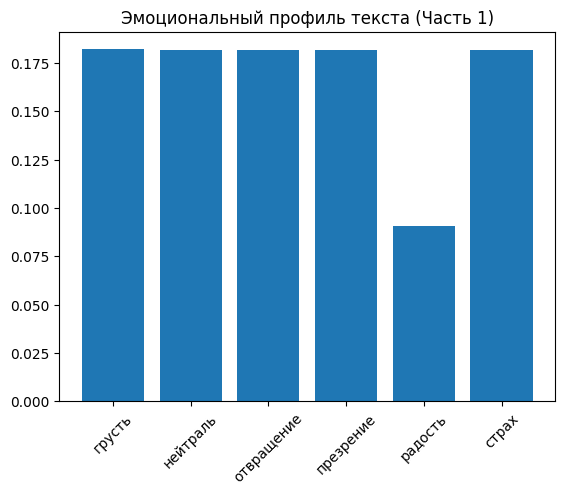

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from pymorphy3 import MorphAnalyzer
from razdel import tokenize
import joblib
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

# 1. Подготовка данных
data = {
    "text": [
        "Белеет парус одинокой в тумане моря голубом...",  # грусть
        "Ярость кипит в моей крови, разрушу всё вокруг!",  # гнев
        "Страх сковывает члены, темнота повсюду...",      # страх
        "Солнце светит ярко, сердце поёт от счастья!",    # радость
        "Презрение к лживым словам и фальшивым улыбкам",  # презрение
        "Неожиданный поворот событий изменил всё",        # удивление
        "Тошнотворный запах разложения заполнил помещение", # отвращение
        "Обычный день без особых событий и переживаний"    # нейтраль
    ],
    "emotion": ["грусть", "гнев", "страх", "радость",
               "презрение", "удивление", "отвращение", "нейтраль"]
}

df = pd.DataFrame(data)

# 2. Предобработка текста
morph = MorphAnalyzer()

def preprocess_text(text):
    tokens = [token.text for token in tokenize(text.lower())]
    lemmas = [morph.parse(word)[0].normal_form for word in tokens]
    return ' '.join(lemmas)

df['processed'] = df['text'].apply(preprocess_text)

# 3. Векторизация текста
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['processed'])
y = df['emotion']

# 4. Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Обучение модели
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

# 6. Оценка модели
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# 7. Сохранение модели
joblib.dump(model, 'emotion_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# 8. Функция предсказания
def analyze_text_emotion(text):
    processed = preprocess_text(text)
    vector = tfidf.transform([processed])
    probas = model.predict_proba(vector)[0]
    return dict(zip(model.classes_, probas))

# 9. Пример использования
def analyze_text_in_parts(text, part_length=100):
    parts = [text[i:i+part_length] for i in range(0, len(text), part_length)]
    results = [analyze_text_emotion(part) for part in parts]
    return results

text = """
Солнце светит ярко, сердце поёт от счастья!
"""

results = analyze_text_in_parts(text)
for i, result in enumerate(results):
    print(f"Часть {i+1}:")
    for emotion, prob in result.items():
        print(f"  {emotion}: {prob:.3f}")

    plt.bar(result.keys(), result.values())
    plt.title(f'Эмоциональный профиль текста (Часть {i+1})')
    plt.xticks(rotation=45)
    plt.show()

# 10. Использование модели RuBERT
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=8,  # 8 эмоций по Экману
    id2label={
        0: "гнев",
        1: "отвращение",
        2: "страх",
        3: "радость",
        4: "грусть",
        5: "удивление",
        6: "презрение",
        7: "нейтраль"
    }
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    save_strategy="epoch",
    load_best_model_at_end=True
)

# Предположим, что emotion_dataset уже определен
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=emotion_dataset
# )
# trainer.train()

def analyze_text_emotion_bert(text):
    processed_text = preprocess_text(text)
    inputs = tokenizer(
        processed_text,
        return_tensors="pt",
        truncation=True,
        max_length=256,
        padding="max_length"
    )
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return {model.config.id2label[i]: round(prob.item(), 3) for i, prob in enumerate(probs[0])}

text2 = """
- Молчи, Соня, я совсем не смеюсь, я ведь и сам знаю, что меня черт тащил. Молчи, Соня, молчи! - повторил он мрачно и настойчиво. - Я все знаю. Все это я уже передумал и перешептал себе, когда лежал тогда в темноте... Все это я сам с собой переспорил, до последней малейшей черты, и все знаю, все! И так надоела, так надоела мне тогда вся эта болтовня! Я все хотел забыть и вновь начать, Соня, и перестать болтать! И неужели ты думаешь, что я как дурак пошел, очертя голову? Я пошел как умник, и это-то меня и сгубило! И неужель ты думаешь, что я не знал, например, хоть того, что если уж начал я себя спрашивать и допрашивать: имею ль я право власть иметь? - то, стало быть, не имею права власть иметь. Или что если задаю вопрос: вошь ли человек? - то, стало быть, уж не вошь человек для меня, а вошь для того, кому этого и в голову не заходит и кто прямо без вопросов идет... Уж если я столько дней промучился: пошел ли бы Наполеон или нет? - так ведь уж ясно чувствовал, что я не Наполеон... Всю, всю муку всей этой болтовни я выдержал, Соня, и всю ее с плеч стряхнуть пожелал: я захотел, Соня, убить без казуистики, убить для себя, для себя одного! Я лгать не хотел в этом даже себе! Не для того, чтобы матери помочь, я убил - вздор! Не для того я убил, чтобы, получив средства и власть, сделаться
"""

results_bert = analyze_text_in_parts(text2, analyze_text_emotion_bert)
for i, result in enumerate(results_bert):
    print(f"Часть {i+1}:")
    for emotion, prob in result.items():
        print(f"  {emotion}: {prob:.3f}")

    plt.bar(result.keys(), result.values())
    plt.title(f'Эмоциональный профиль текста (Часть {i+1})')
    plt.xticks(rotation=45)
    plt.show()


### 1. Предобработка текста для художественных произведений

In [39]:
morph = MorphAnalyzer()

def preprocess_text(text):
    tokens = [token.text for token in tokenize(text)]
    lemmas = [morph.parse(word)[0].normal_form for word in tokens]
    return " ".join(lemmas)

### 2. Загрузка и адаптация модели

In [ ]:
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=8,  # 8 эмоций по Экману
    id2label={
        0: "гнев",
        1: "отвращение",
        2: "страх",
        3: "радость",
        4: "грусть",
        5: "удивление",
        6: "презрение",
        7: "нейтраль"
    }
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",  # Работает в версии 4.3.0+
    logging_dir='./logs',
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotion_dataset  # Датасет с эмоционально размеченными стихами
)
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

### 3. Функция предсказания эмоций

In [ ]:
def analyze_text_emotion(text):
    processed_text = preprocess_text(text)
    inputs = tokenizer(
        processed_text, 
        return_tensors="pt", 
        truncation=True, 
        max_length=256,
        padding="max_length"
    )
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return {model.config.id2label[i]: round(prob.item(), 3) for i, prob in enumerate(probs[0])}

Эмоциональный профиль текста:
гнев: 0.117
отвращение: 0.129
страх: 0.133
радость: 0.124
грусть: 0.122
удивление: 0.132
презрение: 0.123
нейтраль: 0.121


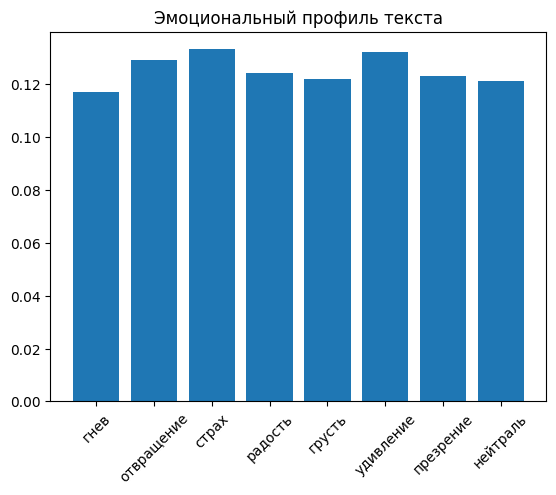

In [ ]:
text = """
Белеет парус одинокой
В тумане моря голубом!..
Что ищет он в стране далекой?
Что кинул он в краю родном?..
Играют волны — ветер свищет,
И мачта гнется и скрыпит…
Увы! он счастия не ищет
И не от счастия бежит!
Под ним струя светлей лазури,
Над ним луч солнца золотой…
А он, мятежный, просит бури,
Как будто в бурях есть покой!
"""

text2 = """
Отмщенье, государь, отмщенье!
Паду к ногам твоим:
Будь справедлив и накажи убийцу,
Чтоб казнь его в позднейшие века
Твой правый суд потомству возвестила,
Чтоб видели злодеи в ней пример.
Погиб поэт! — невольник чести —
Пал, оклеветанный молвой,
С свинцом в груди и жаждой мести,
Поникнув гордой головой!..
Не вынесла душа поэта
Позора мелочных обид,
Восстал он против мнений света
Один, как прежде… и убит!
Убит!.. К чему теперь рыданья,
Пустых похвал ненужный хор
И жалкий лепет оправданья?
Судьбы свершился приговор!
Не вы ль сперва так злобно гнали
Его свободный, смелый дар
И для потехи раздували
Чуть затаившийся пожар?
Что ж? веселитесь… Он мучений
Последних вынести не мог:
Угас, как светоч, дивный гений,
Увял торжественный венок.
Его убийца хладнокровно
Навел удар… спасенья нет:
Пустое сердце бьется ровно,
В руке не дрогнул пистолет.
И что за диво?.. издалека,
Подобный сотням беглецов,
На ловлю счастья и чинов
Заброшен к нам по воле рока;
Смеясь, он дерзко презирал
Земли чужой язык и нравы;
Не мог щадить он нашей славы;
Не мог понять в сей миг кровавый,
На что он руку поднимал!..
И он убит — и взят могилой,
Как тот певец, неведомый, но милый,
Добыча ревности глухой,
Воспетый им с такою чудной силой,
Сраженный, как и он, безжалостной рукой.
Зачем от мирных нег и дружбы простодушной
Вступил он в этот свет завистливый и душный
Для сердца вольного и пламенных страстей?
Зачем он руку дал клеветникам ничтожным,
Зачем поверил он словам и ласкам ложным,
Он, с юных лет постигнувший людей?..
И прежний сняв венок — они венец терновый,
Увитый лаврами, надели на него:
Но иглы тайные сурово
Язвили славное чело;
Отравлены его последние мгновенья
Коварным шепотом насмешливых невежд,
И умер он — с напрасной жаждой мщенья,
С досадой тайною обманутых надежд.
Замолкли звуки чудных песен,
Не раздаваться им опять:
Приют певца угрюм и тесен,
И на устах его печать.
А вы, надменные потомки
Известной подлостью прославленных отцов,
Пятою рабскою поправшие обломки
Игрою счастия обиженных родов!
Вы, жадною толпой стоящие у трона,
Свободы, Гения и Славы палачи!
Таитесь вы под сению закона,
Пред вами суд и правда — всё молчи!..
Но есть и божий суд, наперсники разврата!
Есть грозный суд: он ждет;
Он не доступен звону злата,
И мысли, и дела он знает наперед.
Тогда напрасно вы прибегнете к злословью:
Оно вам не поможет вновь,
И вы не смоете всей вашей черной кровью
Поэта праведную кровь!
"""

result = analyze_text_emotion(text)
print("Эмоциональный профиль текста:")
for emotion, prob in result.items():
    print(f"{emotion}: {prob:.3f}")
    
plt.bar(result.keys(), result.values())
plt.title('Эмоциональный профиль текста')
plt.xticks(rotation=45)
plt.show()